<a href="https://colab.research.google.com/github/spetznick/applied-gpu-programming/blob/colab-s/assignment-4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Assignment 4 Exercise 3

Questions to answer in the report

1.   Run the program with different dimX values. For each one, approximate the FLOPS (floating-point operation per second) achieved in computing the SMPV (sparse matrix multiplication). Report FLOPS at different input sizes in a FLOPS.
2.  Run the program with dimX=1024 and vary nsteps from 100 to 10000. Plot the relative error of the approximation at different nstep. What do you observe?
3.  Compare the performance with and without the prefetching in Unified Memory. How is the performance impact? [Optional: using nvprof to get metrics on UM]


In [60]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Jan  5 14:33:37 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  7


## First exercise of the second assignment


In [92]:
%%writefile hw4_ex3.cu
#include <cublas_v2.h>
#include <cuda_runtime_api.h>
#include <cusparse_v2.h>
#include <math.h>
#include <numeric>
#include <stdlib.h>
#include <sys/time.h>
#include <thrust/device_ptr.h>
#include <thrust/sequence.h>

#define gpuCheck(stmt)                                       \
    do {                                                     \
        cudaError_t err = stmt;                              \
        if (err != cudaSuccess) {                            \
            printf("ERROR. Failed to run stmt %s\n", #stmt); \
            break;                                           \
        }                                                    \
    } while (0)

// Macro to check the cuBLAS status
#define cublasCheck(stmt)                                           \
    do {                                                            \
        cublasStatus_t err = stmt;                                  \
        if (err != CUBLAS_STATUS_SUCCESS) {                         \
            printf("ERROR. Failed to run cuBLAS stmt %s\n", #stmt); \
            break;                                                  \
        }                                                           \
    } while (0)

// Macro to check the cuSPARSE status
#define cusparseCheck(stmt)                                           \
    do {                                                              \
        cusparseStatus_t err = stmt;                                  \
        if (err != CUSPARSE_STATUS_SUCCESS) {                         \
            printf("ERROR. Failed to run cuSPARSE stmt %s\n", #stmt); \
            break;                                                    \
        }                                                             \
    } while (0)

struct timeval t_start, t_end;
void cputimer_start() { gettimeofday(&t_start, nullptr); }
void cputimer_stop(const char *info) {
    gettimeofday(&t_end, nullptr);
    double time = (1000000.0 * (t_end.tv_sec - t_start.tv_sec) + t_end.tv_usec -
                   t_start.tv_usec);
    printf("Timing - %s. \t\tElasped %.0f microseconds \n", info, time);
}

double cputimer_stop() {
    gettimeofday(&t_end, nullptr);
    double time = (1000000.0 * (t_end.tv_sec - t_start.tv_sec) + t_end.tv_usec -
                   t_start.tv_usec);
    return time;
}

// Initialize the sparse matrix needed for the heat time step
void matrixInit(double *A, int *ArowPtr, int *AcolIndx, int dimX,
                double alpha) {
    // Stencil from the finete difference discretization of the equation
    double stencil[] = {1, -2, 1};
    // Variable holding the position to insert a new element
    size_t ptr = 0;
    // Insert a row of zeros at the beginning of the matrix
    ArowPtr[1] = ptr;
    // Fill the non zero entries of the matrix
    for (int i = 1; i < (dimX - 1); ++i) {
        // Insert the elements: A[i][i-1], A[i][i], A[i][i+1]
        for (int k = 0; k < 3; ++k) {
            // Set the value for A[i][i+k-1]
            A[ptr] = stencil[k];
            // Set the column index for A[i][i+k-1]
            AcolIndx[ptr++] = i + k - 1;
        }
        // Set the number of newly added elements
        ArowPtr[i + 1] = ptr;
    }
    // Insert a row of zeros at the end of the matrix
    ArowPtr[dimX] = ptr;
}

float calculateFLOPS(int nvz, double time_ms) {
    // nvz: Number of non-zero elements in the sparse matrix
    // time_ms: Kernel execution time in milliseconds
    if (time_ms < 0.) {
      printf("ERROR: time negative");
    }
    double ops = 2.0f * nvz;  // Each 1*A*temp + 0*tmp operation counts as 1 add and 1 multiply per element
    return ops / (time_ms/ 1000.f);
}

int main(int argc, char **argv) {
    int device = 0;           // Device to be used
    int dimX;                 // Dimension of the metal rod
    int nsteps;               // Number of time steps to perform
    double alpha = 0.4;       // Diffusion coefficient
    double *temp;             // Array to store the final time step
    double *A;                // Sparse matrix A values in the CSR format
    int *ARowPtr;             // Sparse matrix A row pointers in the CSR format
    int *AColIndx;            // Sparse matrix A col values in the CSR format
    int nzv;                  // Number of non zero values in the sparse matrix
    double *tmp;              // Temporal array of dimX for computations
    size_t bufferSize = 0;    // Buffer size needed by some routines
    void *buffer = nullptr;   // Buffer used by some routines in the libraries
    int concurrentAccessQ;    // Check if concurrent access flag is set
    double zero = 0;          // Zero constant
    double one = 1;           // One constant
    double norm;              // Variable for norm values
    double error;             // Variable for storing the relative error
    double tempLeft = 200.;   // Left heat source applied to the rod
    double tempRight = 300.;  // Right heat source applied to the rod
    cublasHandle_t cublasHandle;      // cuBLAS handle
    cusparseHandle_t cusparseHandle;  // cuSPARSE handle
    int prefetch;                     // Flag to prefetch memory

    cusparseSpMatDescr_t Adescriptor;  // Mat descriptor needed by cuSPARSE
    cusparseDnVecDescr_t vecX;         // Input vector descriptor
    cusparseDnVecDescr_t vecY;

    int deviceCount;
    cudaGetDeviceCount(&deviceCount);
    if (deviceCount == 0) {
        printf("No CUDA-capable devices found!\n");
        return -1;
    }
    if (device >= deviceCount || device < 0) {
        printf("Invalid device ID: %d\n", device);
        return -1;
    }
    cudaSetDevice(device);

    // Read the arguments from the command line
    dimX = atoi(argv[1]);
    nsteps = atoi(argv[2]);
    prefetch = atoi(argv[3]);

    // Print input arguments
    printf("The X dimension of the grid is %d \n", dimX);
    printf("The number of time steps to perform is %d \n", nsteps);

    // Get if the cudaDevAttrConcurrentManagedAccess flag is set
    gpuCheck(cudaDeviceGetAttribute(
        &concurrentAccessQ, cudaDevAttrConcurrentManagedAccess, device));

    // Calculate the number of non zero values in the sparse matrix. This number
    // is known from the structure of the sparse matrix
    nzv = 3 * dimX - 6;

    //@@ Insert the code to allocate the temp, tmp and the sparse matrix
    //@@ arrays using Unified Memory
    cputimer_start();
    cudaMallocManaged(&temp, sizeof(double) * dimX);
    cudaMallocManaged(&tmp, sizeof(double) * dimX);
    cudaMallocManaged(&A, sizeof(double) * nzv);
    cudaMallocManaged(&ARowPtr, sizeof(int) * (dimX + 1));
    cudaMallocManaged(&AColIndx, sizeof(int) * nzv);
    cputimer_stop("Allocating device memory");

    // Check if concurrentAccessQ is non zero in order to prefetch memory
    if (concurrentAccessQ && prefetch) {
        cputimer_start();
        //@@ Insert code to prefetch in Unified Memory asynchronously to CPU
        cudaMemPrefetchAsync(temp, sizeof(double) * dimX, cudaCpuDeviceId);
        cudaMemPrefetchAsync(tmp, sizeof(double) * dimX, cudaCpuDeviceId);
        cudaMemPrefetchAsync(A, sizeof(double) * nzv, cudaCpuDeviceId);
        cudaMemPrefetchAsync(ARowPtr, sizeof(int) * (dimX + 1),
                             cudaCpuDeviceId);
        cudaMemPrefetchAsync(AColIndx, sizeof(int) * nzv, cudaCpuDeviceId);
        cputimer_stop("Prefetching GPU memory to the host");
    } else {
        printf("No prefetching\n");
    }

    // Initialize the sparse matrix
    cputimer_start();
    matrixInit(A, ARowPtr, AColIndx, dimX, alpha);
    cputimer_stop("Initializing the sparse matrix on the host");

    // Initiliaze the boundary conditions for the heat equation
    cputimer_start();
    memset(temp, 0, sizeof(double) * dimX);
    temp[0] = tempLeft;
    temp[dimX - 1] = tempRight;
    cputimer_stop("Initializing memory on the host");

    if (concurrentAccessQ && prefetch) {
        cputimer_start();
        //@@ Insert code to prefetch in Unified Memory asynchronously to the GPU
        cudaMemPrefetchAsync(temp, sizeof(double) * dimX, device);
        cudaMemPrefetchAsync(tmp, sizeof(double) * dimX, device);
        cudaMemPrefetchAsync(A, sizeof(double) * nzv, device);
        cudaMemPrefetchAsync(ARowPtr, sizeof(int) * (dimX + 1), device);
        cudaMemPrefetchAsync(AColIndx, sizeof(int) * nzv, device);
        cputimer_stop("Prefetching GPU memory to the device");
    } else {
        // printf("No prefetching\n");
    }

    //@@ Insert code to create the cuBLAS handle
    cublasCreate(&cublasHandle);
    //@@ Insert code to create the cuSPARSE handle
    cusparseCreate(&cusparseHandle);
    //@@ Insert code to set the cuBLAS pointer mode to
    // CUSPARSE_POINTER_MODE_HOST
    // cublasSetPointerMode(cublasHandle, CUSPARSE_POINTER_MODE_HOST); // is
    // there a typo in the instructions?
    cusparseSetPointerMode(cusparseHandle, CUSPARSE_POINTER_MODE_HOST);
    //@@ Insert code to call cusparse api to create the mat descriptor used by
    // cuSPARSE
    cusparseCreateCsr(&Adescriptor, dimX, dimX, nzv, ARowPtr, AColIndx, A,
                      CUSPARSE_INDEX_32I, CUSPARSE_INDEX_32I,
                      CUSPARSE_INDEX_BASE_ZERO, CUDA_R_64F);
    cusparseCreateDnVec(&vecX, dimX, temp, CUDA_R_64F);
    cusparseCreateDnVec(&vecY, dimX, tmp, CUDA_R_64F);
    //@@ Insert code to call cusparse api to get the buffer size needed by the
    // sparse matrix per
    //@@ vector (SMPV) CSR routine of cuSPARSE
    cusparseSpMV_bufferSize(cusparseHandle, CUSPARSE_OPERATION_NON_TRANSPOSE,
                            &one, Adescriptor, vecX, &zero, vecY, CUDA_R_64F,
                            CUSPARSE_SPMV_ALG_DEFAULT, &bufferSize);

    //@@ Insert code to allocate the buffer needed by cuSPARSE
    cudaMalloc(&buffer, bufferSize);

    // Perform the time step iterations
    std::vector<double> flops;
    flops.reserve(nsteps);
    std::vector<double> timesPerIteration;
    timesPerIteration.reserve(nsteps);
    double time_ms = 1.;
    for (int it = 0; it < nsteps; ++it) {
        cputimer_start();
        //@@ Insert code to call cusparse api to compute the SMPV (sparse matrix
        // multiplication) for
        //@@ the CSR matrix using cuSPARSE. This calculation corresponds to:
        //@@ tmp = 1 * A * temp + 0 * tmp
        cusparseSpMV(cusparseHandle, CUSPARSE_OPERATION_NON_TRANSPOSE, &one,
                     Adescriptor, vecX, &zero, vecY, CUDA_R_64F,
                     CUSPARSE_SPMV_ALG_DEFAULT, buffer);
        time_ms = cputimer_stop();
        timesPerIteration.push_back(time_ms);
        // compute flops
        flops.push_back(calculateFLOPS(nzv, time_ms));
        //@@ Insert code to call cublas api to compute the axpy routine using
        // cuBLAS.
        //@@ This calculation corresponds to: temp = alpha * tmp + temp
        cublasDaxpy(cublasHandle, dimX, &alpha, tmp, 1, temp, 1);

        //@@ Insert code to call cublas api to compute the norm of the vector
        // using cuBLAS
        //@@ This calculation corresponds to: ||temp||
        cublasDnrm2(cublasHandle, dimX, temp, 1, &norm);

        // If the norm of A*temp is smaller than 10^-4 exit the loop
        if (norm < 1e-4) break;
    }

    // Calculate the exact solution using thrust
    thrust::device_ptr<double> thrustPtr(tmp);
    thrust::sequence(thrustPtr, thrustPtr + dimX, tempLeft,
                     (tempRight - tempLeft) / (dimX - 1));

    // Calculate the relative approximation error:
    one = -1.;
    //@@ Insert the code to call cublas api to compute the difference between
    // the exact solution
    //@@ and the approximation
    //@@ This calculation corresponds to: temp = -tmp + temp
    cublasDaxpy(cublasHandle, dimX, &one, tmp, 1, temp, 1);

    //@@ Insert the code to call cublas api to compute the norm of the absolute
    // error
    //@@ This calculation corresponds to: || tmp ||
    cublasDnrm2(cublasHandle, dimX, temp, 1, &norm);

    error = norm;
    //@@ Insert the code to call cublas api to compute the norm of temp
    //@@ This calculation corresponds to: || tmp ||
    cublasDnrm2(cublasHandle, dimX, tmp, 1, &norm);

    // Calculate average FLOPS for given size
    double avgLoopTime = std::accumulate(timesPerIteration.begin(), timesPerIteration.end(), 0.) / static_cast<double>(timesPerIteration.size()) ;
    double avgFlops = std::accumulate(flops.begin(), flops.end(), 0.) / static_cast<double>(flops.size()) ;
    printf("The estimated FLOPS are %f, avg. SPMV is %f\n", avgFlops, avgLoopTime);

    // Calculate the relative error
    error = error / norm;
    printf("The relative error of the approximation is %f on nsteps %d\n\n", error, nsteps);

    //@@ Insert the code to destroy the mat descriptor
    cusparseDestroySpMat(Adescriptor);
    cusparseDestroyDnVec(vecX);
    cusparseDestroyDnVec(vecY);

    //@@ Insert the code to destroy the cuSPARSE handle
    cusparseDestroy(cusparseHandle);

    //@@ Insert the code to destroy the cuBLAS handle
    cublasDestroy(cublasHandle);

    //@@ Insert the code for deallocating memory
    cudaFree(temp);
    cudaFree(tmp);
    cudaFree(A);
    cudaFree(ARowPtr);
    cudaFree(AColIndx);
    cudaFree(buffer);

    return 0;
}


Overwriting hw4_ex3.cu


## We compile the saved cuda code using nvcc compiler

In [93]:
!nvcc hw4_ex3.cu -o hw4_ex3 -lcublas -lcusparse
!ls

hw4_ex3  hw4_ex3.cu  sample_data


## Finally, we execute the binary of the compiled code

In [94]:
!./hw4_ex3 1024 100000 1

The X dimension of the grid is 1024 
The number of time steps to perform is 100000 
Timing - Allocating device memory. 		Elasped 83 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 503 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 387 microseconds 
The estimated FLOPS are 988454.694596, avg. SPMV is 6.783990
The relative error of the approximation is 0.613415 on nsteps 100000



In [95]:
!./hw4_ex3 100 100 1
!./hw4_ex3 100 100 1
!./hw4_ex3 100 100 1
!./hw4_ex3 100 100 1
!./hw4_ex3 100 100 1
!./hw4_ex3 1000 100 1
!./hw4_ex3 1000 100 1
!./hw4_ex3 1000 100 1
!./hw4_ex3 1000 100 1
!./hw4_ex3 1000 100 1
!./hw4_ex3 10000 100 1
!./hw4_ex3 10000 100 1
!./hw4_ex3 10000 100 1
!./hw4_ex3 10000 100 1
!./hw4_ex3 10000 100 1
!./hw4_ex3 100000 100 1
!./hw4_ex3 100000 100 1
!./hw4_ex3 100000 100 1
!./hw4_ex3 100000 100 1
!./hw4_ex3 100000 100 1
!./hw4_ex3 1000000 100 1
!./hw4_ex3 1000000 100 1
!./hw4_ex3 1000000 100 1
!./hw4_ex3 1000000 100 1
!./hw4_ex3 1000000 100 1

The X dimension of the grid is 100 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 80 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 526 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 4 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 376 microseconds 
The estimated FLOPS are 99572.826841, avg. SPMV is 55.990000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 100 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 87 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 497 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 433 microseconds

## 2. Varying grid size

In [96]:
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 100 1
!./hw4_ex3 1024 500 1
!./hw4_ex3 1024 500 1
!./hw4_ex3 1024 500 1
!./hw4_ex3 1024 500 1
!./hw4_ex3 1024 500 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 1000 1
!./hw4_ex3 1024 5000 1
!./hw4_ex3 1024 5000 1
!./hw4_ex3 1024 5000 1
!./hw4_ex3 1024 5000 1
!./hw4_ex3 1024 5000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1
!./hw4_ex3 1024 10000 1

The X dimension of the grid is 1024 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 86 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 483 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 419 microseconds 
The estimated FLOPS are 817475.785776, avg. SPMV is 56.100000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024 
The number of time steps to perform is 100 
Timing - Allocating device memory. 		Elasped 80 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 490 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 18 microseconds 
Timing - Initializing memory on the host. 		Elasped 2 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 395 microse

## Prefetching on/off

In [97]:
!./hw4_ex3 16384 1000 1
!./hw4_ex3 16384 1000 0

The X dimension of the grid is 16384 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 100 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 640 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 316 microseconds 
Timing - Initializing memory on the host. 		Elasped 17 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 519 microseconds 
The estimated FLOPS are 12551649.281778, avg. SPMV is 15.164000
The relative error of the approximation is 0.997967 on nsteps 1000

The X dimension of the grid is 16384 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 97 microseconds 
No prefetching
Timing - Initializing the sparse matrix on the host. 		Elasped 915 microseconds 
Timing - Initializing memory on the host. 		Elasped 17 microseconds 
The estimated FLOPS are 10734609.567222, avg. SPMV is 16.968000
The relative error of the approximation is 0.99796

## NCU analysis

In [59]:
# !ncu --section "Occupancy" ./hw4_ex3 1024 1000 1
# !ncu --section "Occupancy" ./hw4_ex3 1024 1000 0
!nvcc hw4_ex3.cu -o hw4_ex3 -lcublas -lcusparse -G -g
!nvprof ./hw4_ex3 16384 1000 0
!nvprof ./hw4_ex3 16384 1000 1

==35994== NVPROF is profiling process 35994, command: ./hw4_ex3 1024 1000 0
The X dimension of the grid is 1024 
The number of time steps to perform is 1000 
Timing - Allocating device memory. 		Elasped 20424 microseconds 
No prefetching
Timing - Initializing the sparse matrix on the host. 		Elasped 481 microseconds 
Timing - Initializing memory on the host. 		Elasped 1 microseconds 
The estimated FLOPS are 454850.088569
The relative error of the approximation is 5.829536 on nsteps 1000

==35994== Profiling application: ./hw4_ex3 1024 1000 0
==35994== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   90.43%  217.09ms      2004  108.33us  30.879us  266.20us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>(cublasNrm2Params<int, double, double>)
                    4.44%  10.668ms      1000  10.667us  8.8310us  13.887us  void cusparse::csrmv_v3_kernel<bool=0, int, int, double, double, double, double, void

In [98]:
data = """The X dimension of the grid is 100
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 80 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 526 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 4 microseconds
Timing - Initializing memory on the host. 		Elasped 0 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 376 microseconds
The estimated FLOPS are 99572.826841, avg. SPMV is 55.990000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 100
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 87 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 497 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds
Timing - Initializing memory on the host. 		Elasped 0 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 433 microseconds
The estimated FLOPS are 74281.599483, avg. SPMV is 82.100000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 100
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 95 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 491 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds
Timing - Initializing memory on the host. 		Elasped 0 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 526 microseconds
The estimated FLOPS are 61374.495111, avg. SPMV is 93.450000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 100
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 100 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 520 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds
Timing - Initializing memory on the host. 		Elasped 0 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 528 microseconds
The estimated FLOPS are 74392.355769, avg. SPMV is 78.600000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 100
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 95 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 546 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds
Timing - Initializing memory on the host. 		Elasped 0 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 411 microseconds
The estimated FLOPS are 63832.778140, avg. SPMV is 79.590000
The relative error of the approximation is 0.885221 on nsteps 100

The X dimension of the grid is 1000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 92 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 469 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 18 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 568 microseconds
The estimated FLOPS are 628817.419865, avg. SPMV is 79.900000
The relative error of the approximation is 0.989061 on nsteps 100

The X dimension of the grid is 1000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 98 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 570 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 18 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 442 microseconds
The estimated FLOPS are 655969.359449, avg. SPMV is 81.470000
The relative error of the approximation is 0.989061 on nsteps 100

The X dimension of the grid is 1000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 78 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 467 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 352 microseconds
The estimated FLOPS are 973536.261622, avg. SPMV is 54.020000
The relative error of the approximation is 0.989061 on nsteps 100

The X dimension of the grid is 1000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 77 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 490 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 15 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 416 microseconds
The estimated FLOPS are 1028988.542614, avg. SPMV is 52.960000
The relative error of the approximation is 0.989061 on nsteps 100

The X dimension of the grid is 1000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 79 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 516 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 391 microseconds
The estimated FLOPS are 1053924.356647, avg. SPMV is 53.290000
The relative error of the approximation is 0.989061 on nsteps 100

The X dimension of the grid is 10000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 81 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 524 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 125 microseconds
Timing - Initializing memory on the host. 		Elasped 12 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 380 microseconds
The estimated FLOPS are 10381145.886982, avg. SPMV is 52.980000
The relative error of the approximation is 0.998911 on nsteps 100

The X dimension of the grid is 10000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 95 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 493 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 123 microseconds
Timing - Initializing memory on the host. 		Elasped 10 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 380 microseconds
The estimated FLOPS are 9427345.634424, avg. SPMV is 53.710000
The relative error of the approximation is 0.998911 on nsteps 100

The X dimension of the grid is 10000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 78 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 527 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 127 microseconds
Timing - Initializing memory on the host. 		Elasped 12 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 372 microseconds
The estimated FLOPS are 8660696.632559, avg. SPMV is 56.410000
The relative error of the approximation is 0.998911 on nsteps 100

The X dimension of the grid is 10000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 112 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 509 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 123 microseconds
Timing - Initializing memory on the host. 		Elasped 12 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 365 microseconds
The estimated FLOPS are 9582581.488184, avg. SPMV is 54.230000
The relative error of the approximation is 0.998911 on nsteps 100

The X dimension of the grid is 10000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 106 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 598 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 162 microseconds
Timing - Initializing memory on the host. 		Elasped 11 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 530 microseconds
The estimated FLOPS are 9921863.212637, avg. SPMV is 63.680000
The relative error of the approximation is 0.998911 on nsteps 100

The X dimension of the grid is 100000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 118 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 1584 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 1173 microseconds
Timing - Initializing memory on the host. 		Elasped 104 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 389 microseconds
The estimated FLOPS are 104780324.490391, avg. SPMV is 52.900000
The relative error of the approximation is 0.999891 on nsteps 100

The X dimension of the grid is 100000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 141 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 1814 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 1601 microseconds
Timing - Initializing memory on the host. 		Elasped 127 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 486 microseconds
The estimated FLOPS are 100208679.782891, avg. SPMV is 57.740000
The relative error of the approximation is 0.999891 on nsteps 100

The X dimension of the grid is 100000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 116 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 1650 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 2379 microseconds
Timing - Initializing memory on the host. 		Elasped 118 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 540 microseconds
The estimated FLOPS are 75520795.204766, avg. SPMV is 58.670000
The relative error of the approximation is 0.999891 on nsteps 100

The X dimension of the grid is 100000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 104 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 1546 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 1194 microseconds
Timing - Initializing memory on the host. 		Elasped 99 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 425 microseconds
The estimated FLOPS are 103751603.673359, avg. SPMV is 52.050000
The relative error of the approximation is 0.999891 on nsteps 100

The X dimension of the grid is 100000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 136 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 1599 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 1242 microseconds
Timing - Initializing memory on the host. 		Elasped 108 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 391 microseconds
The estimated FLOPS are 95678792.280937, avg. SPMV is 58.540000
The relative error of the approximation is 0.999891 on nsteps 100

The X dimension of the grid is 1000000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 152 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 12949 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 12077 microseconds
Timing - Initializing memory on the host. 		Elasped 1765 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 1219 microseconds
The estimated FLOPS are 836075739.157500, avg. SPMV is 55.470000
The relative error of the approximation is 0.999989 on nsteps 100

The X dimension of the grid is 1000000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 151 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 12199 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 11928 microseconds
Timing - Initializing memory on the host. 		Elasped 1706 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 1946 microseconds
The estimated FLOPS are 898698530.485000, avg. SPMV is 58.670000
The relative error of the approximation is 0.999989 on nsteps 100

The X dimension of the grid is 1000000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 172 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 12513 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 12422 microseconds
Timing - Initializing memory on the host. 		Elasped 1718 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 1994 microseconds
The estimated FLOPS are 885437864.741250, avg. SPMV is 56.430000
The relative error of the approximation is 0.999989 on nsteps 100

The X dimension of the grid is 1000000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 155 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 12401 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 12010 microseconds
Timing - Initializing memory on the host. 		Elasped 1708 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 1945 microseconds
The estimated FLOPS are 908894016.305000, avg. SPMV is 54.650000
The relative error of the approximation is 0.999989 on nsteps 100

The X dimension of the grid is 1000000
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 158 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 12436 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 11980 microseconds
Timing - Initializing memory on the host. 		Elasped 1724 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 2064 microseconds
The estimated FLOPS are 829694593.948750, avg. SPMV is 56.500000
The relative error of the approximation is 0.999989 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 86 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 483 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 419 microseconds
The estimated FLOPS are 817475.785776, avg. SPMV is 56.100000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 80 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 490 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 18 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 395 microseconds
The estimated FLOPS are 1073234.362214, avg. SPMV is 54.080000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 82 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 482 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 3 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 423 microseconds
The estimated FLOPS are 1079994.962256, avg. SPMV is 55.400000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 78 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 489 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 424 microseconds
The estimated FLOPS are 609504.248590, avg. SPMV is 61.290000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 100
Timing - Allocating device memory. 		Elasped 82 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 507 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 366 microseconds
The estimated FLOPS are 879125.530671, avg. SPMV is 54.390000
The relative error of the approximation is 0.989319 on nsteps 100

The X dimension of the grid is 1024
The number of time steps to perform is 500
Timing - Allocating device memory. 		Elasped 75 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 500 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 365 microseconds
The estimated FLOPS are 857657.830245, avg. SPMV is 17.938000
The relative error of the approximation is 0.976632 on nsteps 500

The X dimension of the grid is 1024
The number of time steps to perform is 500
Timing - Allocating device memory. 		Elasped 77 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 521 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 355 microseconds
The estimated FLOPS are 779940.811412, avg. SPMV is 20.196000
The relative error of the approximation is 0.976632 on nsteps 500

The X dimension of the grid is 1024
The number of time steps to perform is 500
Timing - Allocating device memory. 		Elasped 84 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 528 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 414 microseconds
The estimated FLOPS are 1069530.199015, avg. SPMV is 15.956000
The relative error of the approximation is 0.976632 on nsteps 500

The X dimension of the grid is 1024
The number of time steps to perform is 500
Timing - Allocating device memory. 		Elasped 75 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 526 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 26 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 371 microseconds
The estimated FLOPS are 1029254.165016, avg. SPMV is 16.062000
The relative error of the approximation is 0.976632 on nsteps 500

The X dimension of the grid is 1024
The number of time steps to perform is 500
Timing - Allocating device memory. 		Elasped 87 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 474 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 398 microseconds
The estimated FLOPS are 1053608.453935, avg. SPMV is 15.596000
The relative error of the approximation is 0.976632 on nsteps 500

The X dimension of the grid is 1024
The number of time steps to perform is 1000
Timing - Allocating device memory. 		Elasped 77 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 518 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 379 microseconds
The estimated FLOPS are 1055532.394609, avg. SPMV is 10.914000
The relative error of the approximation is 0.967024 on nsteps 1000

The X dimension of the grid is 1024
The number of time steps to perform is 1000
Timing - Allocating device memory. 		Elasped 88 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 553 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 356 microseconds
The estimated FLOPS are 658379.460523, avg. SPMV is 20.183000
The relative error of the approximation is 0.967024 on nsteps 1000

The X dimension of the grid is 1024
The number of time steps to perform is 1000
Timing - Allocating device memory. 		Elasped 85 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 544 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 475 microseconds
The estimated FLOPS are 776137.847204, avg. SPMV is 15.409000
The relative error of the approximation is 0.967024 on nsteps 1000

The X dimension of the grid is 1024
The number of time steps to perform is 1000
Timing - Allocating device memory. 		Elasped 96 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 490 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 393 microseconds
The estimated FLOPS are 746088.481992, avg. SPMV is 22.356000
The relative error of the approximation is 0.967024 on nsteps 1000

The X dimension of the grid is 1024
The number of time steps to perform is 1000
Timing - Allocating device memory. 		Elasped 95 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 565 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 404 microseconds
The estimated FLOPS are 663964.335009, avg. SPMV is 17.105000
The relative error of the approximation is 0.967024 on nsteps 1000

The X dimension of the grid is 1024
The number of time steps to perform is 5000
Timing - Allocating device memory. 		Elasped 91 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 549 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 19 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 561 microseconds
The estimated FLOPS are 919313.217945, avg. SPMV is 9.303200
The relative error of the approximation is 0.925499 on nsteps 5000

The X dimension of the grid is 1024
The number of time steps to perform is 5000
Timing - Allocating device memory. 		Elasped 89 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 483 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 18 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 430 microseconds
The estimated FLOPS are 1040169.209256, avg. SPMV is 7.795800
The relative error of the approximation is 0.925499 on nsteps 5000

The X dimension of the grid is 1024
The number of time steps to perform is 5000
Timing - Allocating device memory. 		Elasped 94 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 500 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 22 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 518 microseconds
The estimated FLOPS are 1067355.487549, avg. SPMV is 7.062200
The relative error of the approximation is 0.925499 on nsteps 5000

The X dimension of the grid is 1024
The number of time steps to perform is 5000
Timing - Allocating device memory. 		Elasped 84 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 489 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 447 microseconds
The estimated FLOPS are 1061462.153575, avg. SPMV is 7.158400
The relative error of the approximation is 0.925499 on nsteps 5000

The X dimension of the grid is 1024
The number of time steps to perform is 5000
Timing - Allocating device memory. 		Elasped 97 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 545 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 394 microseconds
The estimated FLOPS are 968750.183001, avg. SPMV is 7.972400
The relative error of the approximation is 0.925499 on nsteps 5000

The X dimension of the grid is 1024
The number of time steps to perform is 10000
Timing - Allocating device memory. 		Elasped 74 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 453 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 14 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 445 microseconds
The estimated FLOPS are 1078997.379946, avg. SPMV is 6.511000
The relative error of the approximation is 0.893252 on nsteps 10000

The X dimension of the grid is 1024
The number of time steps to perform is 10000
Timing - Allocating device memory. 		Elasped 94 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 613 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 419 microseconds
The estimated FLOPS are 1069025.415545, avg. SPMV is 6.556000
The relative error of the approximation is 0.893252 on nsteps 10000

The X dimension of the grid is 1024
The number of time steps to perform is 10000
Timing - Allocating device memory. 		Elasped 105 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 496 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 21 microseconds
Timing - Initializing memory on the host. 		Elasped 3 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 478 microseconds
The estimated FLOPS are 1071147.908722, avg. SPMV is 6.474400
The relative error of the approximation is 0.893252 on nsteps 10000

The X dimension of the grid is 1024
The number of time steps to perform is 10000
Timing - Allocating device memory. 		Elasped 80 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 508 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 20 microseconds
Timing - Initializing memory on the host. 		Elasped 1 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 472 microseconds
The estimated FLOPS are 1098657.569434, avg. SPMV is 6.413700
The relative error of the approximation is 0.893252 on nsteps 10000

The X dimension of the grid is 1024
The number of time steps to perform is 10000
Timing - Allocating device memory. 		Elasped 95 microseconds
Timing - Prefetching GPU memory to the host. 		Elasped 545 microseconds
Timing - Initializing the sparse matrix on the host. 		Elasped 22 microseconds
Timing - Initializing memory on the host. 		Elasped 2 microseconds
Timing - Prefetching GPU memory to the device. 		Elasped 464 microseconds
The estimated FLOPS are 827366.490309, avg. SPMV is 8.466200
The relative error of the approximation is 0.893252 on nsteps 10000
"""

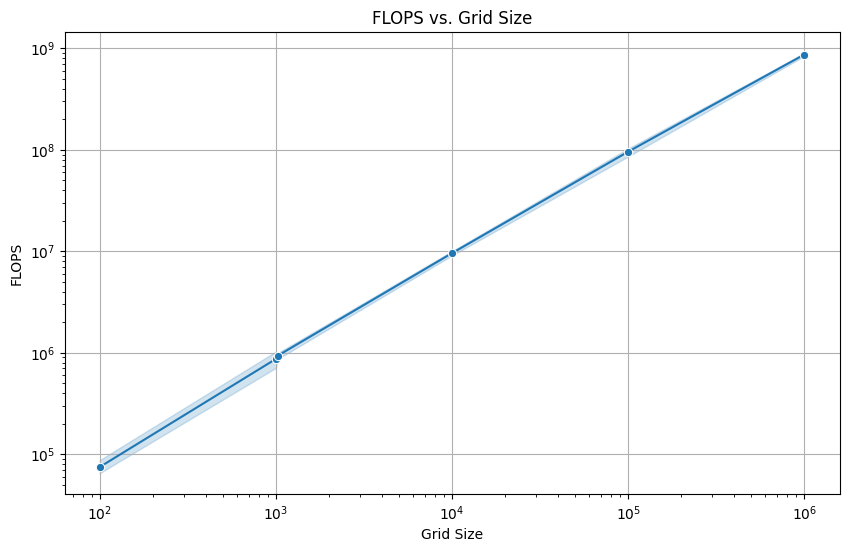

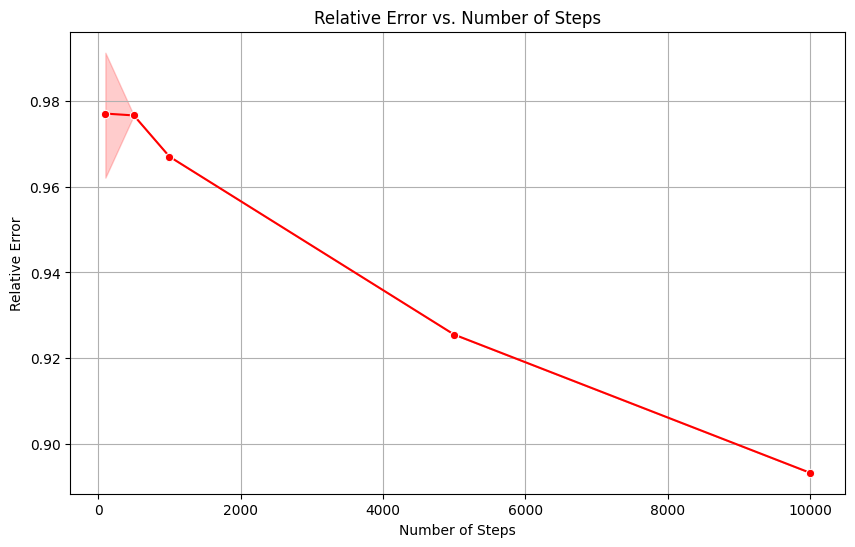

In [99]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Parse the string
def parse_output(data):
    results = []
    # Regular expressions for capturing data
    pattern = (
        r"The X dimension of the grid is (\d+)\s+"  # Grid size
        r"The number of time steps to perform is (\d+)\s+"  # Number of steps
        r"(?:.*?\n)*?"  # Non-greedy match for intermediate lines
        r"The estimated FLOPS are ([\d\.-]+),"  # FLOPS value
        r"(?:.*?\n)*?"  # Non-greedy match for intermediate lines
        r"The relative error of the approximation is ([\d\.]+) on nsteps (\d+)"  # Error and steps
    )
    for match in re.finditer(pattern, data, re.DOTALL):
        grid_size = int(match.group(1))
        nsteps = int(match.group(2))
        flops = float(match.group(3))
        error = float(match.group(4))

        results.append({
            "grid_size": grid_size,
            "nsteps": nsteps,
            "flops": flops,
            "error": error,
        })

    return results

# Extract data
# Clean input data to remove any non-breaking spaces or unwanted characters
data = data.replace("\xa0", " ").strip()
parsed_data = parse_output(data)

# Create DataFrame
df = pd.DataFrame(parsed_data)

# Plot 1: FLOPS vs. Grid Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="grid_size", y="flops", marker="o")
plt.semilogx()
plt.semilogy()
plt.title("FLOPS vs. Grid Size")
plt.xlabel("Grid Size")
plt.ylabel("FLOPS")
plt.grid()
plt.show()

# Plot 2: Relative Error vs. Number of Steps
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="nsteps", y="error", marker="o", color="red")
plt.title("Relative Error vs. Number of Steps")
plt.xlabel("Number of Steps")
plt.ylabel("Relative Error")
plt.grid()
plt.show()
